## Packages

In [139]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [156]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data(r'C:\Users\Furkan\Desktop\Assignment-5\dataset\dataset')

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


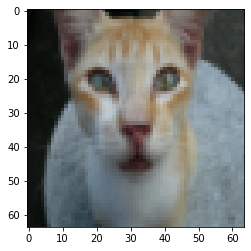

In [157]:
# Example of a picture
index = 11
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [158]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [159]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [160]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [179]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    
    np.random.seed(1)
    parameters = {}
    parameters["W1"] = np.random.randn(n_h,n_x)*0.1
    parameters["b1"] = np.full((n_h,1),0.1)
    parameters["W2"] = np.random.rand(n_h,n_h)*0.1
    parameters["b2"] = np.full((n_h,1),0.06)
    return parameters

In [180]:
def linear_activation_forward(X,parameters):
    def sigmoid(Z):
        return 1 / (1 + np.exp(-Z))

    def ReLu(Z):
        return np.maximum(0,Z)
    Z1 = np.dot(parameters["W1"],X) + parameters["b1"]
    
    A = ReLu(Z1)
    
    Z2 = np.dot(parameters["W2"],Z1) + parameters["b2"]
    
    AL = sigmoid(Z2)
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
    
    
    return AL , Z1


In [181]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cost
    """
    
    m=Y.shape[1]
    cost = (- 1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * (np.log(1 - AL)))
    return cost

In [182]:
def linear_activation_backward(AL,cost,X,Y,parameters,Z1):
    
    """
    Implement the backward propagation
    
    Arguments:
    X -- input data
    cost -- cost
    
    Returns:
    grads --  A dictionary with the gradients
             grads["dW1"]
             grads["db1"]
             grads["dW2"]
             grads["db2"]
             
    """    
    """"""
    def deriv_ReLu(Z):
        return Z > 0
    
    grads = {}
    m = X.shape[1]
    dZ2 = AL - Y
    
    grads["dW2"] = 1 / m * dZ2.dot(AL.T)
    grads["db2"] = 1 / m * np.sum(dZ2)
    dZ1 = (parameters["W2"].T).dot(dZ2) * deriv_ReLu(Z1)
    
    grads["dW1"] = 1 / m * dZ1.dot(X.T)
    grads["db1"] = 1 / m * np.sum(dZ1)
    
    return grads


In [183]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
             parameters["W1"]
             parameters["b1"]
             parameters["W2"]
             parameters["b2"]
    """
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]

    return parameters

In [184]:
def predict(test_x, test_y, parameters):
    
    """
    Predict test data
    test_x -- test data
    test_y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
    accuracy -- accuracy of your model
    """
    probs = linear_activation_forward(test_x,parameters)[0]
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == test_y) * 100
    return accuracy


In [185]:
def plot_loss(costs):

    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.show()


In [186]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters_deep((n_x, n_h, n_y))
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### 
        AL,Z1 = linear_activation_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
        
        
        # Backward propagation.
        ### START CODE HERE ### 
        grads = linear_activation_backward(AL,cost,X,Y,parameters,Z1)
        ### END CODE HERE ###

        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

Cost after iteration 0: 5.620251295872822
Cost after iteration 100: 4.706719817591735
Cost after iteration 200: 4.562837348429283
Cost after iteration 300: 4.532336252996358
Cost after iteration 400: 4.50370327404753
Cost after iteration 500: 4.4667861525270744
Cost after iteration 600: 4.420817583676315
Cost after iteration 700: 4.371014208104902
Cost after iteration 800: 4.316816092826547
Cost after iteration 900: 4.256475729425436
Cost after iteration 1000: 4.1910721993398035
Cost after iteration 1100: 4.118820883580654
Cost after iteration 1200: 4.034594553169407
Cost after iteration 1300: 3.946033231097357
Cost after iteration 1400: 3.8520382973957923
Cost after iteration 1500: 3.754005103141661
Cost after iteration 1600: 3.652481920840109
Cost after iteration 1700: 3.5477000337520987
Cost after iteration 1800: 3.438458491338595
Cost after iteration 1900: 3.3179340279013787
Cost after iteration 2000: 3.1865634087419386
Cost after iteration 2100: 3.047155538254872
Cost after iterat

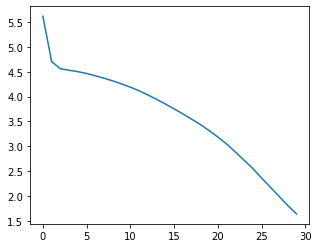

In [188]:
def main():
    parameters , costs = two_layer_model(train_x, train_y, layers_dims, 0.0075, 3000)
    print(f"\nAccuracy is {predict(test_x, test_y, parameters)}")
    plot_loss(costs)
main()